## 4-1 : Computing Cost Surface for Head Loss Downscaling
<em>Created by Tomás Cuevas López in 2024, modified by Casey Dietrich in 2024.</em><br>
<br>
This example will show how to compute a cost surface for the head loss downscaling.<br>
<br>
*Kalpana* has two methods to downscale the ADCIRC flood predictions. In the static downscaling (with previous examples), the water surface is extrapolated as a flat surface until it intersects the ground. For example, if the maximum water level at a vertex is 1.2 m (above MSL), then *Kalpana* will extrapolate to neighboring cells in the downscaled raster with that same water level of 1.2 m, until it finds cells where the ground surface is higher than that value.<br>
<br>
In contrast, in the head loss downscaling, *Kalpana* accounts for the friction due to local land cover and reduces the water levels in the extrapolation. As the water surface is extrapolated from raster cell to raster cell, it loses elevation due to the friction associated with flowing over vegetation. Thus the extrapolated water surface is not flat, but rather it slopes downward until it intersects the ground. (Thus the head loss method will always extrapolate over a shorter distance than the static method.)<br>
<br>
*Kalpana* needs information about the local friction, which it represents as a cost surface. At each raster cell, a cost is precomputed and based on the local land cover. Then these costs are used to reduce the flood extrapolation. **This cost surface only has to be computed once, and then it can be re-used for any storm.**<br>
<br>
We use files from a simulation of Hurricane Ida, which devastated the south Louisiana coast in 2021. To minimize the file sizes in this repository, we created a small mesh that includes Grand Isle and Barataria Bay. Then we simulated Ida by using the NHC best-track storm parameters in a vortex wind model. The simulated storm effects are meant to be useful as an example, but they should not be relied on for any decision making.

## Preliminaries

In [6]:
import os
import shutil
from pathlib import Path
from kalpana.downscalingHeadLoss import preCompCostSurface
from IPython.display import display, Image

## Computing a Cost Surface

A key input is a land-cover raster. For this example, we provide an example land-cover raster (<code>nlcd_2016_land_cover_l48_20210604_clipped.tif</code>), which was created by clipping the NLCD 2016 raster to the extents of our DEM. The full NLCD 2016 raster is too large to host in our GitHub repository, but it can be found in a quick Google search.

In [2]:
######## For more detail about the preCompCostSurface inputs, please read the function's docstring.

## Version of GRASS GIS.
grassVer = 8.3 ## versions 8.2 and 8.3 work

## Full path of the grass location if a existing location will be used.
## Path can't be relative.
pathGrassLocation = os.getcwd()

## Boolean for creating grass location.
## In this example, it must be created.
createGrassLocation = True

## Path to the folder with the input DEM with the ground surface elevations.
cwd = Path(os.getcwd())
pathRasFiles = str(cwd.parent.parent/'adds'/'ida')

## Name(s) of input DEM(s) with the ground surface elevations.
rasterFiles = 'CUDEM_merged_10m_crs3857.tif'

## Path to the folder with the land-cover data.
path_manning = str(Path(os.getcwd()).parent.parent/'adds'/'manning')

## full path of the land cover DEM
manningRasPath = os.path.join(path_manning, "nlcd_2016_land_cover_l48_20210604_clipped_epsg3857.tif")

## rules list to convert from land cover to manning
manningLandCover = os.path.join(path_manning, "landCover_manning.txt")

## Projection to use.
## In this example, we use pseudo-Mercator (3857), but a user could also use UTM (e.g. 6344, 6345).
epsg = 3857

## Full path of the output dem with the raw cost.
pathOutRawCostRas = os.path.join(pathGrassLocation, 'rawCostRaster.tif')

## Full path of the output dem with the total cost.
pathOutTotalCostRas = os.path.join(pathGrassLocation, 'totalCostRaster.tif')

## Full path of the output downscaling DEM.
## In locations where the downscaling DEM does not have bathy,
## cells with water land cover class are set to bathymetry 0 so water cells are included in the calculations.
pathOutDownDemCorr = os.path.join(pathGrassLocation, 'downDemCorr.tif')

We use the <code>preCompCostSurface</code> function to precompute the cost surface. A few parameters are hard-wired below, and we recommend the user keep to these values. This process can take several hours, but again it only needs to be done once.

In [4]:
preCompCostSurface(grassVer, createGrassLocation, pathGrassLocation, pathRasFiles, rasterFiles, epsg, manningRasPath, manningLandCover, 
                                    pathOutRawCostRas, pathOutTotalCostRas, pathOutDownDemCorr, nameGrassLocation=None, createLocMethod='from_raster', URConstant=1, 
                                    k=1, waterClass=11, minArea=20000000, res=5, slopeFactor=-0.2125, walkCoeefs=[0, 1, -1, -1])

2024-07-25 15:42:11.789 | INFO     | kalpana.downscalingHeadLoss:preCompCostSurface:245 - Static downscaling started
2024-07-25 15:42:11.923 | INFO     | kalpana.downscalingHeadLoss:preCompCostSurface:261 -     Start Setup grass environment
2024-07-25 15:42:11.924 | INFO     | kalpana.downscaling:setGrassEnv:346 -         rasters to list:  0.000 min
2024-07-25 15:42:12.174 | INFO     | kalpana.downscaling:setGrassEnv:350 -         create location:  0.004 min
2024-07-25 15:42:12.176 | INFO     | kalpana.downscaling:setGrassEnv:356 -         init grass:  0.000 min
2024-07-25 15:42:15.413 | INFO     | kalpana.downscaling:setGrassEnv:361 -         import raster:  0.054 min
2024-07-25 15:42:15.458 | INFO     | kalpana.downscaling:setGrassEnv:365 -         set downscaling dem:  0.001 min
2024-07-25 15:42:15.459 | INFO     | kalpana.downscalingHeadLoss:preCompCostSurface:270 -     Setup grass environment: 0.06 min
2024-07-25 15:42:39.889 | INFO     | kalpana.downscalingHeadLoss:preCompCostSur

## Corrected DEM based on Cost Surface

After a few hours, the output of this function is a corrected DEM for this region of south Louisiana. Open-water regions are assigned values of zero, to indicate that the extrapolation should not incur a penalty as it extends the flood surface in these regions. However, vegetated regions have higher values, so that the flood levels will be reduced due to friction in these regions. The head loss downscaling method is described in more detail in the manuscript by Rucker et al. (2021):<br>
<br>
https://doi.org/10.1007/s11069-021-04634-8

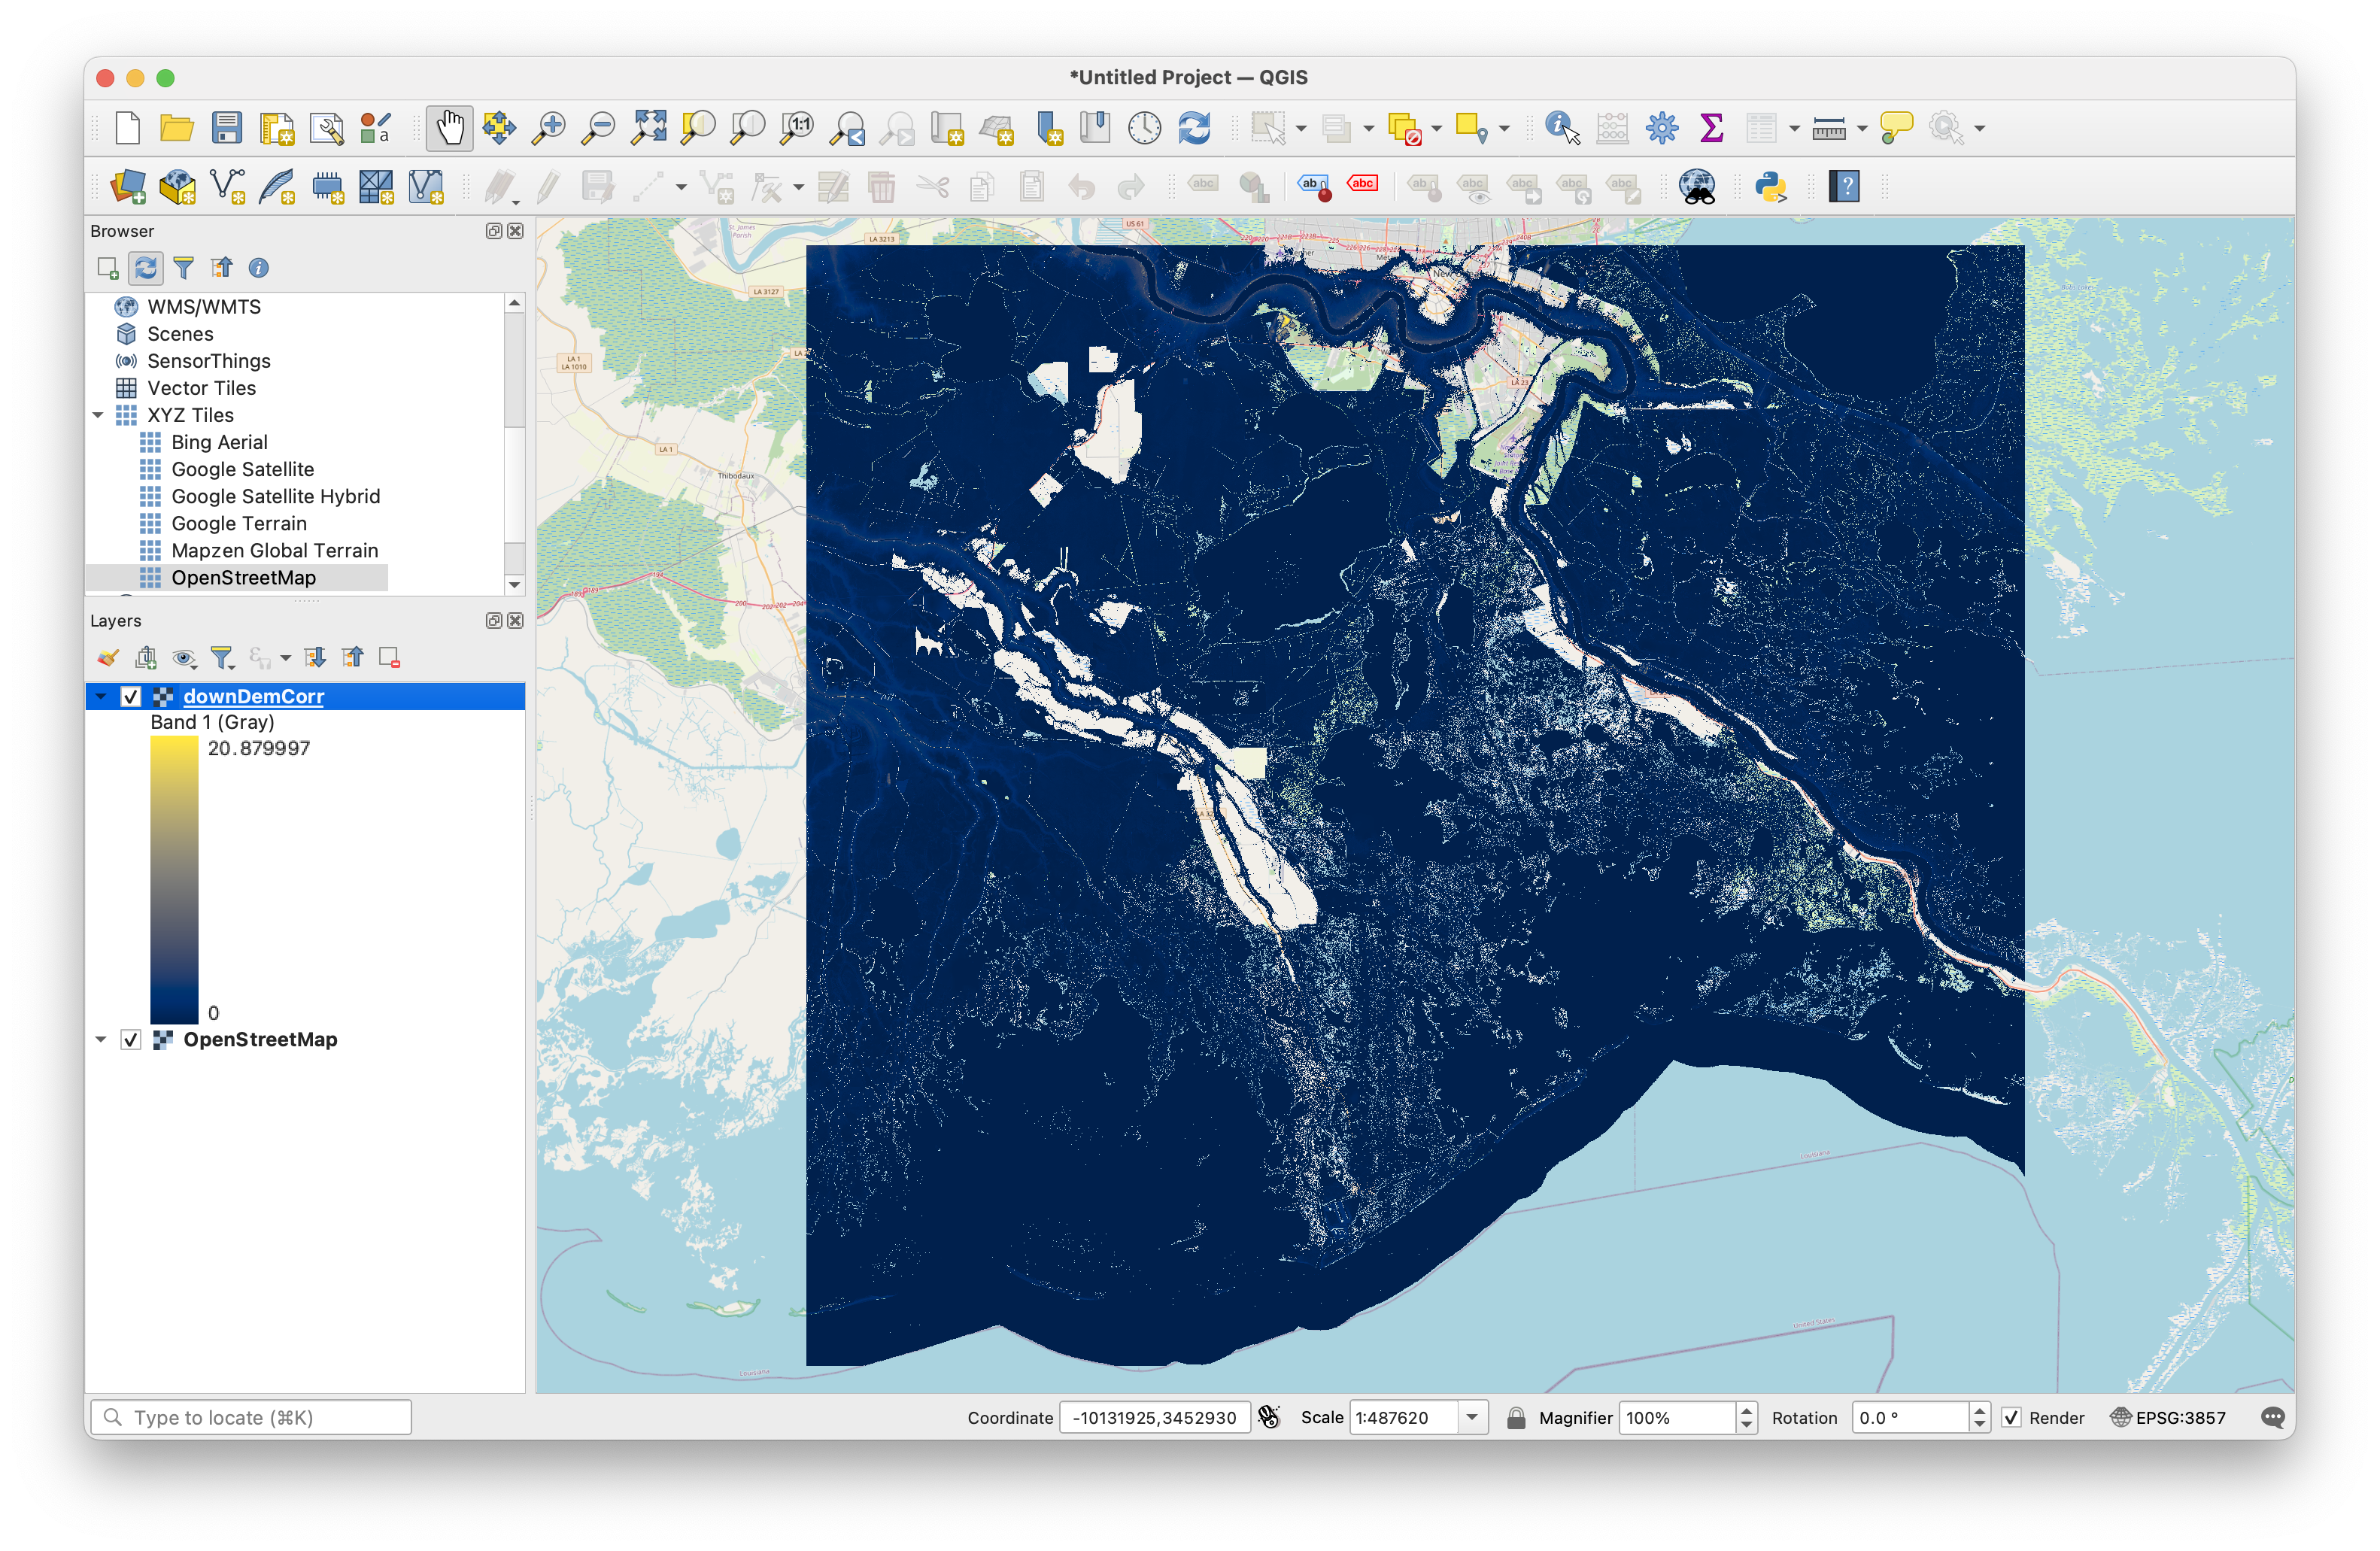

In [7]:
display(Image(filename=r'../../adds/imgs/example_4_1_cost_surface.png', width = 712))

## Housekeeping

The following cell is optional. We include it to keep clean the repository -- it will delete the cost surface that we just created. For most users, this cell is not necessary.

In [8]:
os.remove(pathOutDownDemCorr)
os.remove(pathOutTotalCostRas)
os.remove(pathOutRawCostRas)

shutil.rmtree('grassLoc')

Good luck with Kalpana! See you in future examples!